# Importación de librerias requeridas

In [1]:
#!pip install torchsummary

In [2]:
# -*- coding: utf-8 -*-
from __future__ import print_function, division

# ===========================
# CONFIGURACIÓN INICIAL
# ===========================

# tqdm es una librería para mostrar barras de progreso en ciclos (loops).
# "tqdm.auto" detecta si estamos en un notebook (como Kaggle o Jupyter)
# o en una terminal, y se adapta automáticamente sin mostrar advertencias.
from tqdm.auto import tqdm
tqdm.pandas()   # Integra tqdm con pandas → se ven barras de progreso en operaciones de pandas.

# ===========================
# MANEJO DE WEIGHTS & BIASES (wandb)
# ===========================
# wandb es una herramienta para registrar experimentos de machine learning.
# En Kaggle a veces genera errores o no queremos usarlo.
# Con esta configuración lo desactivamos por defecto y creamos un "plan B"
# para que el código siga funcionando aunque wandb falle o no esté instalado.

import os
os.environ.setdefault("WANDB_DISABLED", "true")  # Kaggle lo desactiva automáticamente

try:
    import wandb  # Intentamos importar wandb
except Exception as e:
    # Si falla la importación, creamos una clase de "simulación"
    # que actúa como reemplazo básico (stub).
    # Así, cuando en el código se llame a wandb.init() o wandb.log(),
    # no se producirá un error.
    class _WandbStub:
        def init(self, *args, **kwargs):
            class _Ctx:
                def __enter__(self): return self
                def __exit__(self, exc_type, exc, tb): pass
            return _Ctx()
        def log(self, *args, **kwargs): pass
        def watch(self, *args, **kwargs): pass
        def finish(self, *args, **kwargs): pass

    wandb = _WandbStub()  # Reemplazamos wandb por el "stub"

# ===========================
# IMPORTACIÓN DE LIBRERÍAS
# ===========================
# Estas librerías cubren diferentes tareas:
# - Numpy/Pandas: análisis de datos
# - PyTorch/Torchvision: redes neuronales
# - Albumentations: aumentación de imágenes
# - Scikit-learn: partición de datos
# - OpenCV/Skimage: procesamiento de imágenes
# - Matplotlib: visualización

import numpy as np
import pandas as pd
from numpy.typing import NDArray
from functools import reduce
from itertools import islice, chain
import math, copy

from PIL import Image

import torch
from torch import nn, Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary  # Muestra la arquitectura de la red

# Albumentations: librería de aumentación de datos para imágenes
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count  # Para paralelizar procesos

import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2

plt.ion()  # Activa el "modo interactivo" → las gráficas se actualizan automáticamente.

# ===========================
# EXPLORACIÓN DE DATOS EN KAGGLE
# ===========================
# Kaggle guarda los datasets en la carpeta "/kaggle/input".
# El siguiente bloque recorre esa carpeta y muestra los primeros 10 archivos encontrados.
# Esto ayuda a verificar qué datos tenemos disponibles sin abrir manualmente el explorador.
for root, dirs, filenames in os.walk('/kaggle/input'):
    for i, filepath in enumerate(filenames):
        if i >= 10:  # Solo mostramos hasta 10 archivos para no saturar la salida
            print()
            break
        print(osp.join(root, filepath))


/kaggle/input/aa-iv-2025-ii-object-localization/sample_submission.csv
/kaggle/input/aa-iv-2025-ii-object-localization/train.csv
/kaggle/input/aa-iv-2025-ii-object-localization/test.csv
/kaggle/input/aa-iv-2025-ii-object-localization/images/videoplayback-1-_mp4-6_jpg.rf.e2195c50e4aa68ffc18f41c80fd7d235.jpg
/kaggle/input/aa-iv-2025-ii-object-localization/images/IMG_4861_mp4-43_jpg.rf.4271f075e21c21ee8dc01731c6a7ea89.jpg
/kaggle/input/aa-iv-2025-ii-object-localization/images/IMG_4861_mp4-56_jpg.rf.2c4bd7a2dd787d0344f2b49af88f21f1.jpg
/kaggle/input/aa-iv-2025-ii-object-localization/images/IMG_3100_mp4-24_jpg.rf.894c40eafa77cd73ff50a69982e3f924.jpg
/kaggle/input/aa-iv-2025-ii-object-localization/images/IMG_4860_mp4-45_jpg.rf.29bb394fd84df979b2a6096746751f42.jpg
/kaggle/input/aa-iv-2025-ii-object-localization/images/IMG_4861_mp4-9_jpg.rf.bcc352b97426c7378bcd8004247f4433.jpg
/kaggle/input/aa-iv-2025-ii-object-localization/images/video_CDC-YOUTUBE_mp4-41_jpg.rf.4f56be4b40c9775509474d515489f5a5

# Ahora, vamos a crear la estructura del dataset

In [3]:
# ===========================
# Configuración básica en PyTorch
# ===========================

torch.manual_seed(32)  
# Fija la semilla para que los resultados sean reproducibles.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Usando {device}')  
# Selecciona GPU si está disponible, de lo contrario usa CPU.

test = torch.ones((100, 100)).to(device)  
# Crea un tensor de prueba en el dispositivo seleccionado (CPU o GPU).

del test  
# Elimina el tensor de la memoria.

torch.cuda.empty_cache()  
# Limpia la memoria de la GPU, dejándola lista para entrenar modelos.


Usando cuda


In [4]:
# ===========================
# CONFIGURACIÓN DE DIRECTORIOS Y PARÁMETROS
# ===========================

DATA_DIR = '/kaggle/input/aa-iv-2025-ii-object-localization'  # Carpeta donde Kaggle guarda el dataset (solo lectura)
WORK_DIR = '/kaggle/working'                                  # Carpeta de trabajo (aquí se guardan outputs y resultados)
BATCH_SIZE = 32                                               # Tamaño de lote (batch) para el entrenamiento del modelo

# Ruta donde están guardadas las imágenes
img_dir = osp.join(DATA_DIR, "images")

# ===========================
# CARGA DEL DATASET
# ===========================

# Leemos el archivo CSV de entrenamiento que contiene:
# - nombre de la imagen
# - coordenadas de la caja delimitadora (bounding box: xmin, ymin, xmax, ymax)
# - clase del objeto
df = pd.read_csv(osp.join(DATA_DIR, "train.csv"))

# ===========================
# MAPEO DE CLASES A IDs
# ===========================

# Diccionario para convertir las clases (texto) en identificadores numéricos
# Diccionario que asigna un número a cada clase:
# - "no-mask" → 0
# - "mask"    → 1
obj2id  = {'no-mask':0,'mask':1}

# Diccionario inverso: convertir IDs numéricos en nombres de clases
id2obj  = {0:'no-mask',1:'mask'}

# Crear nueva columna "class_id" en el DataFrame con el valor numérico de la clase
df["class_id"] = df["class"].map(obj2id)

# ===========================
# SELECCIÓN DE COLUMNAS ÚTILES
# ===========================

# Definimos qué columnas necesitamos realmente del dataset
columns_f=['filename','xmin','ymin','xmax','ymax','class','class_id']

# Nos quedamos únicamente con esas columnas
df = df[columns_f].copy()


# Exploremos un poco los datos

In [5]:
df

,filename,xmin,ymin,xmax,ymax,class,class_id
0,video_CDC-YOUTUBE_mp4-63_jpg.rf.2f4f64f6ef712f...,315,249,468,374,no-mask,0
1,IMG_4860_mp4-36_jpg.rf.01a053cabddff2cdd19f04e...,257,237,299,264,no-mask,0
2,IMG_1491_mp4-12_jpg.rf.9df64033aebef44b8bb9a6a...,291,245,582,449,mask,1
3,IMG_4861_mp4-64_jpg.rf.74ab6d1da8a1fa9b8fbb576...,231,229,577,420,no-mask,0
4,IMG_9950-1-_mp4-83_jpg.rf.74dca33810c23ba144d8...,107,168,515,469,no-mask,0
...,...,...,...,...,...,...,...
214,videoplayback-1-_mp4-58_jpg.rf.bfdf3258d74f87d...,408,168,465,212,no-mask,0
215,video_CDC-YOUTUBE_mp4-36_jpg.rf.5d17748e659665...,181,232,350,356,mask,1
216,IMG_4861_mp4-38_jpg.rf.880a11c3ebf59b3d0cf988f...,112,179,413,438,no-mask,0
217,How-to-Properly-Wear-a-Face-Mask-_-UC-San-Dieg...,268,134,382,422,no-mask,0


In [6]:
# ===========================
# CARGA DE UNA IMAGEN DE EJEMPLO
# ===========================

# Construimos la ruta completa a un archivo de imagen específico.
# En este caso, "image_00077.jpeg" dentro de la carpeta del dataset.
img_filename = osp.join(DATA_DIR, "images", 'IMG_1493_mp4-21_jpg.rf.c5a3e237451e64e0674d5b0a6d556c25.jpg')

# 1) Lectura de la imagen con OpenCV (cv2)
# ----------------------------------------
# OpenCV lee las imágenes en formato BGR (Blue, Green, Red) por defecto.
img1 = cv2.imread(img_filename)

# Convertimos de BGR a RGB para que los colores sean correctos al visualizar con matplotlib.
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# 2) Lectura de la misma imagen con skimage (io.imread)
# -----------------------------------------------------
# La función `io.imread` de scikit-image lee las imágenes directamente en formato RGB,
# por lo tanto no es necesario hacer la conversión de colores.
img2 = io.imread(img_filename)


In [7]:
# Mostramos la forma original de la imagen: (alto, ancho, canales) → (H, W, C)
print(img1.shape)

# Transponemos para pasar a formato (canales, alto, ancho) → (C, H, W),
# que es el requerido por PyTorch. -> como se vió en clase, pytorch trabaja
# con Channel first, no Channel last.
print(img1.transpose((2,0,1)).shape)


(640, 640, 3)
(3, 640, 640)


In [8]:
# ===========================
# ANÁLISIS EXPLORATORIO DE IMÁGENES
# ===========================

# Obtenemos la lista de nombres de archivos de las imágenes desde el DataFrame
list_image = list(df.filename)

# Inicializamos listas vacías donde guardaremos información de cada imagen
data_shape = []   # Guardará la forma completa de la imagen (alto, ancho, canales)
data_dim = []     # Guardará el número de dimensiones (ej: 2 para escala de grises, 3 para RGB)
data_w = []       # Guardará el ancho de la imagen
data_h = []       # Guardará la altura de la imagen

# Recorremos todas las imágenes con una barra de progreso (tqdm)
for i in tqdm(list_image):  # Puede tardar unos ~40 segundos en recorrer todo
    # Construimos la ruta completa de la imagen
    ruta_imagen = osp.join(img_dir, i)
    
    # Leemos la imagen con skimage → obtenemos forma y número de dimensiones
    imagen = io.imread(ruta_imagen)
    shapes = imagen.shape      # Ejemplo: (300, 400, 3)
    dimen = imagen.ndim        # Ejemplo: 3 si es RGB, 2 si es escala de grises
    
    # Leemos la imagen con PIL → obtenemos ancho y alto
    imagen = Image.open(ruta_imagen)
    w, h = imagen.size         # size devuelve (ancho, alto)
    
    # Guardamos toda la información en las listas
    data_w.append(w)
    data_h.append(h)
    data_shape.append(shapes)
    data_dim.append(dimen)

# Construimos un DataFrame con toda la información recopilada
data_w_h = pd.DataFrame(
    [list_image, data_shape, data_dim, data_w, data_h]
).T.rename(columns={0:'filename', 1:'shapes', 2:'ndim', 3:'w', 4:'h'})


  0%|          | 0/219 [00:00<?, ?it/s]

In [9]:
# Contamos cuántas imágenes tienen cada ancho (w).
# Sirve para verificar si todas las imágenes tienen el mismo tamaño
# o si hay variación en el dataset. -> tambien puedes hacerlo con 'h'
data_w_h['w'].value_counts()
# Esto quiere decir que existen 219 imagenes con 'w' -> 640

w
640    219
Name: count, dtype: int64

In [10]:
# Contamos cuántas imágenes tienen cada número de dimensiones (ndim).
# ndim = 3 → imágenes a color (RGB)
data_w_h['ndim'].value_counts()
# Se evidencian 219 imagenes con 3 canales (RGB)

ndim
3    219
Name: count, dtype: int64

In [11]:
# Contamos cuántas veces aparece cada forma (alto, ancho, canales) en el dataset.
# Ejemplo de salida:
# (300, 400, 3) → 120 imágenes con 300x400 píxeles y 3 canales (RGB)
# (224, 224, 3) → 80 imágenes con 224x224 píxeles y 3 canales (RGB)
data_w_h['shapes'].value_counts()
# Importante: Si hay múltiples tamaños, será necesario aplicar un redimensionamiento 'RESIZE' antes de entrenar la red neuronal.

shapes
(640, 640, 3)    219
Name: count, dtype: int64

In [12]:
# Contamos cuántas veces aparece cada clase en el dataset (en formato de texto).
# Esto muestra la distribución de imágenes entre las clases "mask" y "no-mask".
df['class'].value_counts()

class
no-mask    135
mask        84
Name: count, dtype: int64

In [13]:
# Verificamos si existen errores en las coordenadas de las cajas delimitadoras (bounding boxes).

# Caso 1: xmin >= xmax
# Esto indicaría que el lado izquierdo de la caja está a la derecha del lado derecho → caja inválida.

# Caso 2: ymin >= ymax
# Esto indicaría que la parte superior de la caja está por debajo de la parte inferior → caja inválida.
df[df['xmin']>=df['xmax']].shape, df[df['ymin']>=df['ymax']].shape

((0, 7), (0, 7))

# Normalizamos los bounding box

In [14]:
# Mostramos estadísticas básicas (min, max, promedio, etc.)
# de las coordenadas de las bounding boxes: ymin, ymax, xmin, xmax.
# Sirve para verificar que las cajas estén dentro de los rangos esperados
# y detectar valores anómalos en las anotaciones.
print(df[["ymin", "ymax", "xmin", "xmax"]].describe())

             ymin        ymax        xmin        xmax
count  219.000000  219.000000  219.000000  219.000000
mean   175.296804  371.278539  217.068493  446.849315
std     67.509690   97.632620  108.656136  104.015128
min      3.000000  145.000000    0.000000  146.000000
25%    134.000000  333.000000  154.000000  382.500000
50%    168.000000  394.000000  204.000000  466.000000
75%    224.000000  431.500000  274.500000  513.000000
max    420.000000  640.000000  557.000000  640.000000


In [15]:
# ===========================
# NORMALIZACIÓN DE COORDENADAS DE LAS BOUNDING BOXES
# ===========================

# Definimos la altura y el ancho reales de las imágenes del dataset.
# En este caso todas son de 640 x 640 píxeles.
h_real = 640
w_real = 640

# Normalizamos las coordenadas de las cajas delimitadoras dividiéndolas
# entre la altura o el ancho correspondiente.
# De esta forma los valores quedan entre 0 y 1, lo que facilita el entrenamiento.
df[["ymin", "ymax"]] = df[["ymin", "ymax"]].div(h_real, axis=0)
df[["xmin", "xmax"]] = df[["xmin", "xmax"]].div(w_real, axis=0)

In [16]:
# Estadisticos normalizados
print(df[["ymin", "ymax", "xmin", "xmax"]].describe())

             ymin        ymax        xmin        xmax
count  219.000000  219.000000  219.000000  219.000000
mean     0.273901    0.580123    0.339170    0.698202
std      0.105484    0.152551    0.169775    0.162524
min      0.004687    0.226562    0.000000    0.228125
25%      0.209375    0.520312    0.240625    0.597656
50%      0.262500    0.615625    0.318750    0.728125
75%      0.350000    0.674219    0.428906    0.801562
max      0.656250    1.000000    0.870313    1.000000


In [17]:
# Ahora visualizamos el df con los bbox normalizados
df

,filename,xmin,ymin,xmax,ymax,class,class_id
0,video_CDC-YOUTUBE_mp4-63_jpg.rf.2f4f64f6ef712f...,0.492188,0.389062,0.731250,0.584375,no-mask,0
1,IMG_4860_mp4-36_jpg.rf.01a053cabddff2cdd19f04e...,0.401562,0.370312,0.467187,0.412500,no-mask,0
2,IMG_1491_mp4-12_jpg.rf.9df64033aebef44b8bb9a6a...,0.454688,0.382812,0.909375,0.701562,mask,1
3,IMG_4861_mp4-64_jpg.rf.74ab6d1da8a1fa9b8fbb576...,0.360938,0.357812,0.901563,0.656250,no-mask,0
4,IMG_9950-1-_mp4-83_jpg.rf.74dca33810c23ba144d8...,0.167187,0.262500,0.804688,0.732812,no-mask,0
...,...,...,...,...,...,...,...
214,videoplayback-1-_mp4-58_jpg.rf.bfdf3258d74f87d...,0.637500,0.262500,0.726562,0.331250,no-mask,0
215,video_CDC-YOUTUBE_mp4-36_jpg.rf.5d17748e659665...,0.282813,0.362500,0.546875,0.556250,mask,1
216,IMG_4861_mp4-38_jpg.rf.880a11c3ebf59b3d0cf988f...,0.175000,0.279687,0.645312,0.684375,no-mask,0
217,How-to-Properly-Wear-a-Face-Mask-_-UC-San-Dieg...,0.418750,0.209375,0.596875,0.659375,no-mask,0


In [18]:
# ===========================
# PARTICIÓN ENTRENAMIENTO / VALIDACIÓN (estratificada)
# ===========================
# Dividimos el DataFrame 'df' en dos subconjuntos:
#  - train_df: datos para entrenar el modelo (75%)
#  - val_df:   datos para validar el modelo (25%)
#
# Parámetros clave:
#  - stratify=df['class_id']  → mantiene la misma proporción de clases en
#    train y val (muy importante si el dataset está desbalanceado).
#  - test_size=0.25           → 25% de los datos va a validación.
#  - random_state=42           → semilla para reproducibilidad del split.
#
# Requisitos:
#  - La columna 'class_id' debe existir, que de hecho, está!
#  - Cada clase debe tener muestras suficientes para poder estratificar
#    (si alguna clase tiene muy pocos ejemplos, puede dar ValueError)
train_df, val_df = train_test_split(
    df, stratify=df['class_id'], test_size=0.25, random_state=52
)

# Tamaños resultantes de cada partición
print(train_df.shape)
print(val_df.shape)

(164, 7)
(55, 7)


**Importante**: El set de entrenamiento debe tener información acerca de la clase y las coordenadas correspondientes a los bbox

In [19]:
# ===========================
# DISTRIBUCIÓN DE CLASES EN TRAIN (en %)
# ===========================
# ahora verificamos que la distribución de las clases se mantengan en el train
# Útil para verificar que el split estratificado mantuvo el balance de clases.
train_df['class'].value_counts(normalize=True) * 100

class
no-mask    61.585366
mask       38.414634
Name: proportion, dtype: float64

Hay que tener presente que el conjunto de prueba solo contiene el nombre de archivo de cada imagen (se puede verificar en la data), por lo que tenemos que generar predicciones y enviarlas a la competencia de Kaggle.

In [20]:
# ---------------------------------------------------------------------------
# FIRMAS DE TRANSFORMACIONES (TIPADO)
# ---------------------------------------------------------------------------
# Cada transformación debe recibir y devolver un diccionario de numpy arrays
# con claves como 'image', 'bbox' y/o 'class_id'. Esto ayuda a documentar
# la interfaz esperada por el pipeline de datos.
transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],  # entrada: sample dict
    transform_func_inp_signature     # salida: sample dict (misma estructura)
]

class maskDataset(Dataset):
    """
    Location image dataset
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  # Añadir parámetro para tamaño de salida
    ) -> None:
        # df: DataFrame con las anotaciones. Se asume un orden de columnas donde:
        #  [0] = 'filename', [1:5] = ['xmin','ymin','xmax','ymax'], y además 'class_id'.
        # root_dir: carpeta donde viven las imágenes.
        # labeled: si True, el __getitem__ añade 'bbox' y 'class_id' al sample.
        # transform: lista/callable de transformaciones que operan sobre el dict sample.
        # output_size: tamaño de redimensionado de imagen (w, h). Si las bboxes están
        #              normalizadas en [0,1], no requieren ajuste al hacer resize.
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  # Almacenar el tamaño de salida
        
    def __len__(self):
        # Tamaño del dataset = número de filas del DataFrame.
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        # Soporte para indexación con tensores (DataLoader puede pasar un tensor).
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        # Construye la ruta absoluta a la imagen y la carga con skimage (RGB por defecto).
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        #img_name = os.path.join(self.root_dir, self.df.iloc[idx]['filename'])
        image = io.imread(img_name)
        #image = cv2.imread(img_name)
        
        
        #print(f"Dimensiones originales de la imagen: {image.shape}")  # Agregar para depuración
        if image is None:
            # Falla temprano si la imagen no existe o no pudo cargarse.
            raise FileNotFoundError(f"Image not found: {img_name}")
            
        # Normalización de canales:
        # - Si viene en escala de grises (ndim == 2), conviértela a 3 canales.
        # - Si viene con alfa (RGBA), descarta el canal alfa y deja RGB.
        if image.ndim == 2:  # Si la imagen está en escala de grises
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convertir a RGB
            # Nota: típicamente sería cv2.COLOR_GRAY2RGB si la fuente es escala de grises.
            # Aquí se mantiene tal cual (no modificar código) y se deja la advertencia.
        elif image.shape[2] == 4:  # Si la imagen es RGBA
            image = image[:, :, :3] 
            
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            # cv2.resize espera (width, height). Asegúrate de pasar en ese orden.
            # Si las bboxes estuvieran en píxeles, habría que reescalarlas también.
            # Si están normalizadas en [0,1], no requieren ajuste.
            image = cv2.resize(image, self.output_size)  # Redimensionar la imagen si es necesario, en este punto
            # no es necesario porque las imagenes estan 640 x 640
        
        # Armar el sample básico (siempre incluye la imagen en formato np.ndarray HxWxC).
        sample = {'image': image}
        
        if self.labeled:
            # Read labels
            # class_id: entero con la clase. Se empaqueta como np.array de forma (1,).
            img_class = self.df.class_id.iloc[idx]
            # bbox: se toma por posición de columnas [1:5] → ['xmin','ymin','xmax','ymax'].
            # IMPORTANTE: esto depende del orden de columnas en df.
            img_bbox = self.df.iloc[idx, 1:5]

            # Convertir a numpy y fijar tipos. bbox → float; class_id → int.
            # bbox queda con forma (1, 4) y class_id con forma (1,).
            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})
        
        if self.transform:
            # Aplica la(s) transformación(es) sobre el diccionario sample.
            sample = self.transform(sample)
        
        # Devuelve el sample listo para el DataLoader / modelo.
        return sample


In [21]:
def draw_bbox(img, bbox, color,thickness: int = 3):
    # Dibuja un único cuadro delimitador (bounding box) sobre una imagen.
    # Parámetros:
    #   img      : np.ndarray (imagen en formato BGR si se usa OpenCV)
    #   bbox     : iterable con 4 enteros/píxeles en el orden (xmin, ymin, xmax, ymax)
    #              IMPORTANTE: estas coordenadas deben estar en píxeles, no normalizadas.
    #   color    : tupla BGR (por ejemplo, (255,0,0) para azul en OpenCV)
    #   thickness: grosor de la línea del rectángulo
    # Retorna:
    #   img con el rectángulo dibujado (la operación modifica la imagen in-place)
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
    return img

def normalize_bbox(bbox, h: int, w: int):
    """Escala las coordenadas normalizadas al tamaño real de la imagen."""
    # Convierte una caja en formato normalizado [0,1] a píxeles enteros según (w, h).
    # Parámetros:
    #   bbox: iterable [xmin_norm, ymin_norm, xmax_norm, ymax_norm] en [0,1]
    #   h   : altura de la imagen en píxeles
    #   w   : ancho de la imagen en píxeles
    # Retorna:
    #   lista [xmin_px, ymin_px, xmax_px, ymax_px] como enteros
    return [
        int(bbox[0] * w),  # xmin
        int(bbox[1] * h),  # ymin
        int(bbox[2] * w),  # xmax
        int(bbox[3] * h),  # ymax
    ]

def draw_bboxes(imgs, bboxes, colors,thickness):
    """Dibuja múltiples cuadros delimitadores en imágenes, escalando según h y w."""
    # Dibuja una lista de bounding boxes sobre una lista de imágenes.
    # Parámetros:
    #   imgs    : lista de imágenes (np.ndarray) de igual longitud que bboxes y colors
    #   bboxes  : lista de cajas en píxeles [(xmin,ymin,xmax,ymax), ...]
    #             NOTA: esta función asume que las cajas YA están en píxeles.
    #   colors  : lista de colores BGR por cada imagen/caja (o reutilizadas externamente)
    #   thickness: grosor del rectángulo
    # Retorna:
    #   lista de imágenes con las cajas dibujadas
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color,thickness)
    return imgs

def draw_classes(imgs, classes, colors, origin, prefix: str ='',fontScale : int = 2):
    """Dibuja las clases en las imágenes."""
    # Escribe el nombre de la clase sobre cada imagen.
    # Parámetros:
    #   imgs     : lista de imágenes (np.ndarray)
    #   classes  : iterable de ids de clase (p. ej., [[1], [0], ...] o [1,0,...])
    #   colors   : lista de colores BGR para el texto
    #   origin   : punto (x, y) donde iniciar el texto en cada imagen
    #   prefix   : texto opcional para anteponer (por ejemplo, "pred: ")
    #   fontScale: tamaño de fuente en OpenCV
    # Dependencias externas esperadas:
    #   - Un diccionario global 'id2obj' para mapear id → nombre de clase.
    # Nota: la variable 'c' usada más abajo no está definida en este bloque.
    #       Se mantiene tal cual por requerimiento del enunciado.
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)):
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX,
            fontScale , color, 2, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin,thickness,fontScale):
    """
    Combina las funciones anteriores para dibujar cuadros delimitadores
    y clases en las imágenes.
    """
    # Flujo:
    #   1) Verifica que todas las listas tengan longitud > 0.
    #   2) Si hay un solo color, lo replica para todas las imágenes.
    #   3) Dibuja las cajas.
    #   4) Dibuja las etiquetas de clase.
    # Parámetros:
    #   imgs, classes, bboxes: listas alineadas por índice
    #   colors               : lista de colores BGR (o uno solo para todos)
    #   origin               : punto (x,y) para el texto
    #   thickness            : grosor del rectángulo
    #   fontScale            : tamaño del texto
    # Retorna:
    #   lista de imágenes con predicciones (cajas + etiquetas) dibujadas
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors,thickness)
    imgs = draw_classes(imgs, classes, colors, origin,"",fontScale)
    return imgs


In [22]:
h, w, c = 256, 256, 3

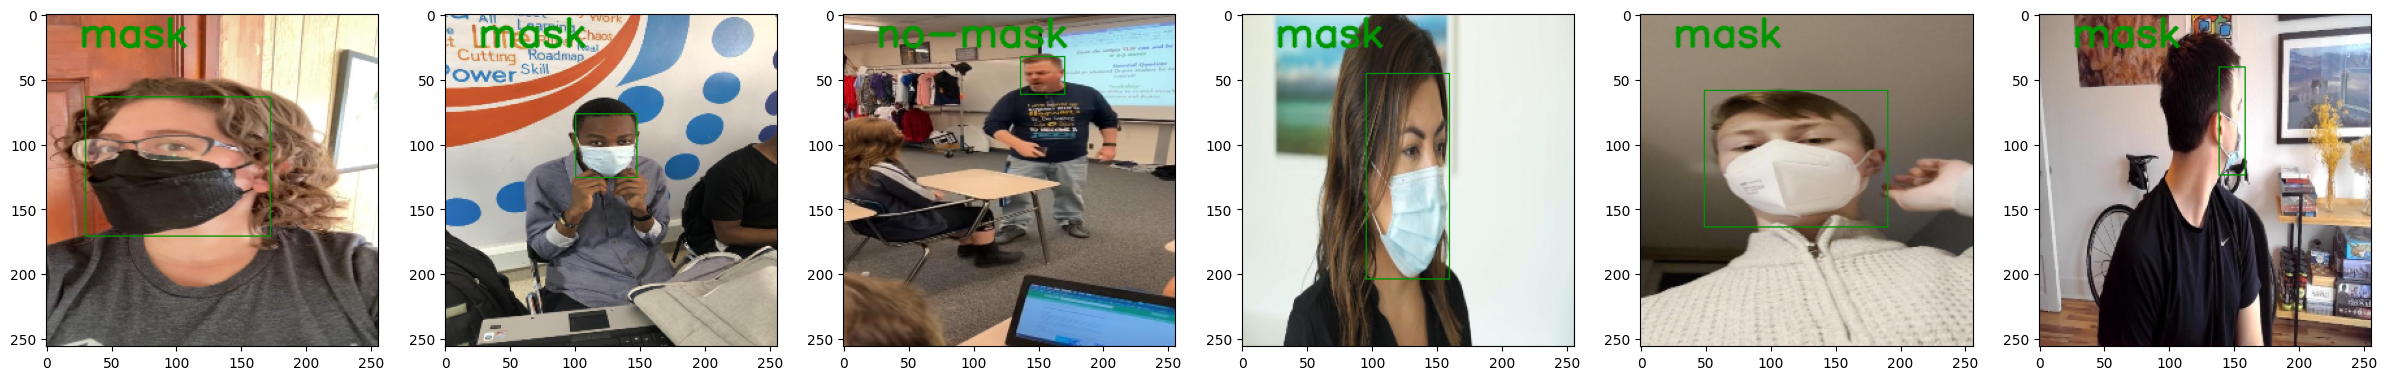

In [23]:
# ===========================
# VISUALIZACIÓN DE MUESTRAS CON CAJAS Y CLASES
# ===========================

# Carpeta raíz donde están las imágenes del split de entrenamiento
train_root_dir = osp.join(DATA_DIR, "images")#, "train"

# Instanciamos el Dataset con el DataFrame de train y forzamos tamaño de salida (w, h)
# Nota: 'w' y 'h' deben estar definidos previamente (por ejemplo, 640, 640).
train_ds = maskDataset(train_df, root_dir=train_root_dir,output_size=(w,h))

# Número de imágenes a mostrar y desde qué índice empezar
num_imgs = 6
start_idx = 0

# Tomamos 'num_imgs' muestras consecutivas a partir de 'start_idx'
samples = [train_ds[i] for i in range(start_idx, num_imgs)]

# Extraemos por separado las imágenes, bboxes y clases de cada sample
imgs = [s['image'] for s in samples]
# Convertimos las cajas normalizadas [0,1] a píxeles con (w,h) de salida
bboxes = [normalize_bbox(s['bbox'].squeeze(),h,w) for s in samples]
classes = [s['class_id'] for s in samples]

# Dibujamos predicciones: cajas + etiquetas
# - colors: lista con un color (BGR) que se reutiliza para todas las imágenes
# - origin: punto (x,y) para el texto (10% del ancho y alto)
# - thickness y fontScale: grosor de línea y tamaño de fuente
imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (int(w*0.1), int(h*0.1)),thickness = 1,fontScale=1)#(150, 10)

# Creamos una figura grande y colocamos cada imagen en una subgráfica
fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

# Mostramos el collage de imágenes con sus cajas y clases
plt.show()

# Transfer Learning con FasterRCNN_ResNet50_FPN

Se seleccionó este modelo porque combina la alta precisión de Faster R-CNN con la capacidad de la FPN para detectar objetos pequeños como el tapabocas en el rostro. Además, dentro de la literatura se presenta un buen desempelo en la detección de objetos. Articulo: https://www.researchgate.net/publication/357495395_An_Automated_Real-Time_Face_Mask_Detection_System_Using_Transfer_Learning_with_Faster-RCNN_in_the_Era_of_the_COVID-19_Pandemic

In [24]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

# Pesos preentrenados
weights_fasterRcnn_resnet50_2 = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# Crear el modelo con pesos
model_fasterRcnn_resnet50_2 = fasterrcnn_resnet50_fpn(weights=weights_fasterRcnn_resnet50_2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 149MB/s]  


In [25]:
class FasterRCNNResNetFeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FasterRCNNResNetFeatureExtractor, self).__init__()
        # Extract ResNet features layers up to the adaptive average pooling
        self.features = nn.Sequential(*list(model.children())[:-1])
        # ResNet includes AdaptiveAvgPool2d as part of the main model, so we just need to flatten and add dropout
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        out = self.features(x)
        out = self.flatten(out)
        out = self.dropout(out)
        return out
        
resnet_backbone = model_fasterRcnn_resnet50_2.backbone.body
# Instantiate the ResNet feature extractor
pretrained_model = FasterRCNNResNetFeatureExtractor(resnet_backbone).to(device)
pretrained_model.eval()

FasterRCNNResNetFeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): FrozenBatchNorm2d(64, eps=0.0)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 6

In [26]:
summary(pretrained_model, (3, 640, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           9,408
 FrozenBatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
         MaxPool2d-4         [-1, 64, 160, 160]               0
            Conv2d-5         [-1, 64, 160, 160]           4,096
 FrozenBatchNorm2d-6         [-1, 64, 160, 160]             128
              ReLU-7         [-1, 64, 160, 160]               0
            Conv2d-8         [-1, 64, 160, 160]          36,864
 FrozenBatchNorm2d-9         [-1, 64, 160, 160]             128
             ReLU-10         [-1, 64, 160, 160]               0
           Conv2d-11        [-1, 256, 160, 160]          16,384
FrozenBatchNorm2d-12        [-1, 256, 160, 160]             512
           Conv2d-13        [-1, 256, 160, 160]          16,384
FrozenBatchNorm2d-14        [-1, 256, 1

# Normalización de imagen

In [27]:
# ===========================
# CÁLCULO DE MEDIA Y DESVIACIÓN ESTÁNDAR (por canal) DEL DATASET
# ===========================
# Objetivo: estimar las estadísticas de color (mean y std de R, G, B) para
# usarlas luego en una normalización tipo torchvision.transforms.Normalize(mean, std).
train_ds = maskDataset(train_df, root_dir=train_root_dir,output_size=(w,h))#,output_size=(255,255)

# Acumuladores para medias/STD por canal (R,G,B)
means = np.zeros(3)
stds = np.zeros(3)
n_images = 0

# Recorremos todas las imágenes del split de entrenamiento
for x in train_ds:
    img = x['image']  # Imagen en formato HxWxC (RGB). 
                      # (Si la imagen estuviera en uint8 [0..255], las medias/STD saldrán en esa escala.)
                      # .astype(np.float32) comentado: convertir a float puede ser útil para mayor precisión.
    n_images += 1

    # Para cada canal (0=R, 1=G, 2=B), calculamos la media y la STD de la imagen actual
    for channel in range(3):
        channel_pixels = img[..., channel]  # Todos los píxeles del canal
        # Se acumula la media y la desviación estándar por imagen (promedio de medias, no ponderado por píxeles)
        means[channel] += np.mean(channel_pixels)
        stds[channel] += np.std(channel_pixels)

# Promediamos sobre el número de imágenes para obtener la estimación final por canal
means /= n_images
stds /= n_images

In [28]:
# INSPECCIÓN DE ESTADÍSTICAS POR CANAL
# ===========================
# 'means': medias por canal [R, G, B] calculadas en el bloque anterior.
# 'stds' : desviaciones estándar por canal [R, G, B].
# Útil para configurar transforms.Normalize(mean, std).
print(means)
print(stds)

[150.77282761 140.56651864 133.61833405]
[64.31656643 63.01682912 61.56061379]


# Transformación de imagenes

In [29]:
# ===========================
# TRANSFORMACIONES DE IMAGEN (pipeline estilo "sample" dict)
# Cada transformación recibe un diccionario 'sample' y lo devuelve modificado.
# Convención de 'sample':
#   sample = {
#       'image': np.ndarray o torch.Tensor,
#       'bbox' : np.ndarray(1,4) opcional (xmin, ymin, xmax, ymax) normalizado o en píxeles según tu flujo,
#       'class_id': np.ndarray(1,) opcional
#   }
# ===========================

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # Cambiamos el orden de ejes:
        # numpy:  H x W x C  (canal al final)
        # torch:  C x H x W  (es el que necesitamos Channel first, NCHW)
        image = image.transpose((2, 0, 1))

        # Convertimos a Tensor de tipo float32.
        # NOTA:
        # - Aquí NO se divide por 255. Si tu imagen venía en uint8 [0..255],
        #   ahora será float32 en el mismo rango [0..255].
        # - Asegúrate de que las estadísticas (mean/std) que usarás más adelante
        #   estén en la misma escala que la imagen (0..255 o 0..1).
        image = torch.from_numpy(image).float()

        # Actualizamos el diccionario 'sample' in-place
        sample.update({'image': image})
        return sample


class Normalizer(object):
    
    def __init__(self, stds, means):
        """
        Arguments:
            stds: array de longitud 3 con la desviación estándar por canal (RGB).
            means: array de longitud 3 con la media por canal (RGB).
        """
        self.stds = stds
        self.means = means
    
    def __call__(self, sample):
        """
        Sample: diccionario que contiene:
            image: imagen en formato (C, H, W) y tipo float (misma escala que means/stds).
        Returns:
            'image' con normalización por canal: (x - mean) / std
        """
        image = sample['image']
        
        # Importante:
        # - Este bloque usa las variables globales 'means' y 'stds' (no self.means/self.stds).
        #   Se mantiene tal cual (no modificar código). Asegúrate de haber definido
        #   'means' y 'stds' previamente en el notebook con la misma escala que 'image'.
        for channel in range(3):
            image[channel] = (image[channel] - means[channel]) / stds[channel]

        sample['image'] = image
        return sample


class TVTransformWrapper(object):
    """Torch Vision Transform Wrapper
    """
    def __init__(self, transform: torch.nn.Module):
        # Recibe un transform de torchvision (que espera torch.Tensor CxHxW)
        self.transform = transform
        
    def __call__(self, sample):
        # Aplica el transform SOLO sobre 'image'.
        # Útil para cosas como transforms.Normalize, Resize (si operan en tensor), etc.
        sample['image'] = self.transform(sample['image'])
        return sample


class AlbumentationsWrapper(object):
    
    def __init__(self, transform):
        # Recibe un 'Compose' (u otro) de Albumentations, que trabaja con numpy HxWxC.
        self.transform = transform
    
    def __call__(self, sample):
        # Aplica Albumentations sobre imagen y bboxes.
        # Requiere que 'sample["image"]' esté en formato numpy HxWxC (no tensor).
        # Formato y normalización de 'bboxes' dependen de cómo se configuró la
        # transformación (p. ej., 'bbox_params' en A.Compose: formato 'pascal_voc' o 'yolo').
        transformed = self.transform(
            image=sample['image'], 
            bboxes=sample['bbox'],
            #category_ids=sample['class_id']  # Si activas esta línea, asegúrate de configurar bbox_params con label_fields=['category_ids']
        )

        # Albumentations devuelve dict; actualizamos 'sample' con los resultados.
        sample['image'] = transformed['image']
        sample['bbox'] = np.array(transformed['bboxes'])
        return sample


Se hace uso de la librería de aumentación de imagenes en https://albumentations.ai/docs/examples/pytorch_classification/

### 1. **HorizontalFlip (p=1)**

-   gira la imagen de izquierda a derecha y ajusta las bounding boxes


### 2. **RandomBrightnessContrast (p=0.3)**

-   cambia de manera aleatoria el brillo y el contraste 

### 3. **HueSaturationValue (p=0.3)**

-   cambia aleatoriamente el tono (color), la saturación (intensidad) y el valor (brillo).

### 4. **Affine (p=0.2)**

-   aplica escalado (más grande o más pequeño) y pequeños desplazamientos.
    
### 5. **MotionBlur (p=0.4)**

-   aplica un desenfoque que simula movimiento.


Se experimentó con distintas transformaciones de datos con el objetivo de representar situaciones propias del mundo real. Por ejemplo, se aplicó MotionBlur para simular imágenes borrosas, RandomBrightnessContrast para reflejar escenarios con mucha o poca iluminación y transformaciones de escalado para reconocer objetos en diferentes tamaños. Inicialmente se intentó emplear rotaciones, pero al analizar los resultados se identificaron inconsistencias en las bounding boxes, por lo que se descartó esta opción. De esta experiencia se concluyó que no todas las transformaciones contribuyen de manera positiva al rendimiento del modelo; algunas, por el contrario, generan imágenes con demasiado ruido que dificultan el aprendizaje. Por esta razón, se optó por asignar probabilidades bajas (p) a la mayoría de las transformaciones, de manera que el dataset mantuviera un balance adecuado entre diversidad y calidad.

In [30]:
# ===========================
# DATA AUGMENTATION (Albumentations) + Wrapper para el pipeline
# ===========================

train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=1),    # Volteo horizontal SIEMPRE (p=1). Cambia imagen y ajusta las bboxes.
    
    
    # Color e iluminación
   A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.2
    ),
    A.HueSaturationValue(
        hue_shift_limit=10,
        sat_shift_limit=15,
        val_shift_limit=10,
        p=0.1
    ),
     # Transformación de recorte (puede mejorar la robustez del modelo)
     A.Affine(
        scale=(0.95, 1.05),     # Simula scale_limit=0.05
        translate_percent=(0.05, 0.05), # Simula shift_limit=0.05
        rotate=(-15, 15),       # Simula rotate_limit=15
        p=0.2
    ),
    A.MotionBlur(blur_limit=3,p=0.5)

    ],
    bbox_params=A.BboxParams(
        format='albumentations',   # Formato de bboxes esperado por Albumentations:
                                   # [x_min, y_min, x_max, y_max] NORMALIZADO en [0,1].
                                   # (Coherente con nuestro flujo si ya normalizaste las bboxes).
        label_fields=[],           # No se pasan etiquetas (category_ids) a las transforms.
                                   # Si quisieras mantener labels sincronizadas, añade la lista aquí
                                   # y provee 'category_ids' en el sample.
    )
)

# En nuestro pipeline, las transforms operan sobre 'sample' (dict).
# Usamos un wrapper que aplica Albumentations sobre sample['image'] y sample['bbox'].
dataaug_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations)  # Aplica flip y actualiza bboxes.
    ]
)


In [31]:
import shutil
import re  # Usaremos expresiones regulares para extraer números de cualquier nombre de archivo

# ============================================================
# 1) PREPARAR CARPETA DE SALIDA PARA IMÁGENES FINALES
#    (BORRAR SI EXISTE Y CREAR DE NUEVO)
# ============================================================
if os.path.exists('data_final'):
    shutil.rmtree('data_final')   # Eliminamos la carpeta anterior para empezar “limpio”

os.mkdir('data_final')            # Carpeta donde guardaremos: imágenes aumentadas + originales

# Dataset base SIN resize (conserva tamaño original).
# Nota: el resize está comentado a propósito para no alterar dimensiones.
train_ds_da = maskDataset(train_df, root_dir=train_root_dir) # ,output_size=(255,255) No usamos resize para que conservé el tamaño original

# ============================================================
# 2) CÁLCULO ROBUSTO DEL ÚLTIMO ÍNDICE A PARTIR DEL NOMBRE
#    Funciona con .jpg o .jpeg y con nombres arbitrarios.
#    Ej.: 'IMG_4921-2...jpg' → extrae '4921' y usa el ÚLTIMO grupo de dígitos.
# ============================================================
def extract_any_int(name: str) -> int:
    base, _ = os.path.splitext(name)  # separa nombre y extensión
    nums = re.findall(r'\d+', base)   # encuentra todos los grupos de dígitos
    return int(nums[-1]) if nums else -1  # toma el último grupo si existe; si no, -1

last_index = train_ds_da.df.filename.apply(extract_any_int).max()
if last_index < 0:    # si ningún archivo tenía dígitos, empezamos desde 0
    last_index = 0
index = int(last_index) + 1   # primer índice nuevo para imágenes sintéticas

# ============================================================
# 3) GENERAR IMÁGENES AUMENTADAS Y SUS ANOTACIONES
#    - Recorremos el dataset de train
#    - Aplicamos data augmentation (p. ej., flip horizontal)
#    - Guardamos imagen aumentada
#    - Registramos fila con filename, class_id y bbox
# ============================================================
rows = []
for j in range(0,1):  # Cantidad de imágenes sintéticas por imagen original (aquí: 1)
    iterador = iter(train_ds_da)
    for i in range(len(train_ds_da)):
        x = next(iterador)                 # sample original: {'image', 'bbox', 'class_id', ...}
        x_transformed = copy.deepcopy(x)   # copiamos para no modificar el original
        x_transformed = dataaug_transforms(x_transformed)  # aplicamos augmentations

        # Construimos nombre único para la imagen aumentada
        filename = f"image_id_{index}_t{j}.jpeg"

        # Recuperamos la imagen aumentada (numpy HxWxC, RGB)
        image = x_transformed['image']  # .astype('uint8') opcional si fuera necesario

        # Guardamos en disco (cv2 usa BGR, por eso convertimos de RGB→BGR)
        cv2.imwrite("data_final/"+filename, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        # Registramos anotación:
        #   - filename de la nueva imagen
        #   - class_id (tal como viene en el sample)
        #   - bbox (xmin, ymin, xmax, ymax)
        # Importante: aquí se asume que las bboxes se mantienen en el mismo formato
        # (p. ej., normalizadas [0,1]) que maneja el resto del pipeline.
        #row = [filename, [id2obj[class_id] for class_id in x_transformed["class_id"]], *x_transformed['bbox'].squeeze()]
        row = [filename, *x_transformed["class_id"], *x_transformed['bbox'].squeeze()]
        rows.append(row)
        index += 1

# Construimos DataFrame con las anotaciones de las imágenes aumentadas
aug_df = pd.DataFrame(rows, columns=['filename', 'class_id', 'xmin', 'ymin', 'xmax', 'ymax',])
# (Opcional) Mapear class_id → nombre de clase usando train_df como referencia:
# aug_df["class"] = aug_df.class_id.replace(train_df.set_index('class_id')['class'])
# (Opcional) Si quisieras bboxes en píxeles, multiplicar por [w,h,w,h]:
# aug_df[['xmin', 'ymin', 'xmax', 'ymax']]*=hw_real

# ============================================================
# 4) COPIAR TAMBIÉN LAS IMÁGENES ORIGINALES A 'data_final'
#    (tendremos en una misma carpeta originales + aumentadas)
# ============================================================
source = train_root_dir
destination = 'data_final'
allfiles = os.listdir(source)

for f in allfiles:
    if f in train_df['filename'].values:   # solo las del split de entrenamiento
        src_path = os.path.join(source, f)
        dst_path = os.path.join(destination, f)
        shutil.copy(src_path, dst_path)

# ============================================================
# 5) UNIR ANOTACIONES: ORIGINALES + AUMENTADAS
#    Y AGREGAR LA COLUMNA 'class' A PARTIR DE 'class_id'
# ============================================================
dataframe_with_dataaugmentation = pd.concat([train_df, aug_df], ignore_index=True)
dataframe_with_dataaugmentation['class'] = dataframe_with_dataaugmentation['class_id'].replace(id2obj)

# Mostramos el DataFrame final con todas las anotaciones
dataframe_with_dataaugmentation


,filename,xmin,ymin,xmax,ymax,class,class_id
0,IMG_3100_mp4-2_jpg.rf.048fb5479fbbd0f46b30db2a...,0.117188,0.251563,0.671875,0.670312,mask,1
1,IMG_7309_JPG_jpg.rf.a0d52fd98d6d55b26272bf138a...,0.393750,0.303125,0.575000,0.493750,mask,1
2,videoplayback-1-_mp4-27_jpg.rf.aa58ae92a45fde5...,0.534375,0.131250,0.667188,0.242188,no-mask,0
3,How-to-Properly-Wear-a-Face-Mask-_-UC-San-Dieg...,0.371875,0.182812,0.621875,0.798438,mask,1
4,IMG_1492_mp4-14_jpg.rf.8cfe9d7e27fda0de028b547...,0.192188,0.231250,0.745313,0.642188,mask,1
...,...,...,...,...,...,...,...
323,image_id_5295680176929_t0.jpeg,0.371875,0.264062,0.781250,0.664062,mask,1
324,image_id_5295680176930_t0.jpeg,0.232813,0.279687,0.710938,0.684375,mask,1
325,image_id_5295680176931_t0.jpeg,0.485059,0.382320,0.770058,0.612922,mask,1
326,image_id_5295680176932_t0.jpeg,0.562500,0.217188,0.803125,0.401562,no-mask,0


In [32]:
# ===========================
# VERIFICACIÓN RÁPIDA DE FORMAS (nº de filas y columnas)
# ===========================
# Muestra un par de tuplas:
#  - Primero: shape de train_df  → (n_filas_train, n_columnas)
#  - Segundo: shape de dataframe_with_dataaugmentation → (n_filas_total, n_columnas)
train_df.shape, dataframe_with_dataaugmentation.shape


((164, 7), (328, 7))

In [33]:
# ===========================
# CONTEO DE ARCHIVOS EN LA CARPETA FINAL
# ===========================
# Listamos todos los archivos (imágenes originales + aumentadas) en 'data_final'.
allfiles = os.listdir('data_final')

# Nota: el comentario de abajo habla de "mover" archivos, pero aquí solo contamos.
# 'len(allfiles)' devuelve cuántos archivos hay en 'data_final'.
# En un notebook, si esta es la última línea de la celda, el número se muestra automáticamente.
# (Si no fuese la última línea, podrías usar: print(len(allfiles)))
# iterate on all files to move them to destination folder
len(allfiles)


328

Adicionalmente se aplicó nuevamente un pipeline de transformaciones realizando el horizontal flip nuevamente en la mitad de los registros y se aplicó sepia con el fin de alterar la paleta de colores y simula situaciones donde las imágenes provienen de cámaras con baja resolución o antiguas, además también aumentar la robustez del modelo frente a degradaciones visuales.

In [34]:
# ===========================
# PIPELINE DE TRANSFORMACIONES
# - common_transforms: pasos comunes a train y valid/test
# - train_data_augmentations: augmentations solo para entrenamiento
# - train_transforms: augmentations + comunes (en ese orden)
# - eval_transforms: solo comunes (sin augmentations)
# ===========================

common_transforms = [
    ToTensor(),               # Convierte imagen de numpy (H,W,C) → torch.Tensor (C,H,W), float32
    Normalizer(               # Normaliza por canal: (x - mean) / std
        means=means,          
        stds=stds,            
    )
]

train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),   # Flip horizontal con prob. 0.5 (afecta imagen y ajusta bboxes)
    A.ToSepia(p=0.5)
    ],
    bbox_params=A.BboxParams(
        format='albumentations',  # Formato esperado: [xmin, ymin, xmax, ymax] NORMALIZADO en [0,1]
        label_fields=[],          # No pasamos labels aquí; si se usan, agregar lista y proveer en sample
    )
)

# En entrenamiento: primero augmentations (operan sobre numpy HxWxC),
# luego ToTensor() y Normalizer() (operan sobre tensor CxHxW).
train_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations),  # Aplica A.Compose a 'image' y 'bbox'
    ] + common_transforms
)

# En validación/evaluación: NO se aplican augmentations, solo los pasos comunes
# (ToTensor + Normalizer) para mantener consistencia.
eval_transforms = torchvision.transforms.Compose(common_transforms)


In [35]:
# ===========================
# DATASET + DATALOADER (entrenamiento)
# ===========================
# Creamos el Dataset a partir del DataFrame que une originales + aumentadas.
# root_dir='data_final'  → carpeta donde guardamos todas las imágenes (originales y sintéticas).
# transform=train_transforms → aplica (1) augmentations (AlbumentationsWrapper) y (2) pasos comunes (ToTensor + Normalizer).
# output_size=(w,h)      → fuerza que todas las imágenes salgan con el mismo tamaño (p. ej., 640x640).
train_ds = maskDataset(dataframe_with_dataaugmentation, root_dir='data_final', transform=train_transforms,output_size=(w,h)) #train_root_dir

# DataLoader: empaqueta el dataset en lotes (batches) para entrenamiento.
# batch_size=16 → cada iteración entrega 16 muestras (imágenes + labels si labeled=True).
train_data = torch.utils.data.DataLoader(train_ds, batch_size=16)

# Iteramos una sola vez sobre el DataLoader para inspeccionar la forma del tensor de imágenes.
# Esperado en PyTorch (channel-first): [batch, channels, height, width] → (16, 3, h, w)
for x in train_data:
    print(x['image'].size())  # Deberías ver algo como: torch.Size([16, 3, 640, 640])
    break                     # 'break' para no consumir todo el DataLoader en esta comprobación


torch.Size([16, 3, 256, 256])


Nota: Se verifica que el tensor tenga forma [B,C,H,W]

## DEFINICION DE ARQUITECTURA CNN

La **cabeza de clasificación** recibe la salida del backbone y pasa por dos capas ocultas lineales, primero hacia 768 y luego hacia 256 neuronas, cada una acompañada de Batch Normalization y una activación ReLU. Finalmente, una capa lineal proyecta al número de clases.

La **cabeza de regresión** parte también de las características del backbone, pero utiliza una estructura más profunda, es decir, con mayor cantidad de capaz debido a que el problema de regresión es un poco más complejo. Comienza con una capa lineal de 1024 seguida de ReLU, BatchNorm y Dropout, continúa con capas de 512 y 256 neuronas, y termina con una salida de cuatro valores y una activación Sigmoid. Esta activación al final se agregó debido a que las coordenadas de los bounding boxes están normalizadas entre 0 y 1, por lo tanto, la función sigmoide evita que la red produzca coordenadas inválidas, además, puede mejorar la estabilidad en el entrenamiento pues las salidas pueden oscilar en rangos muy grandes al inicio del entrenamiento, lo que puede ralentizar o inestabilizar la convergencia. La sigmoide “suaviza” estas predicciones.

Por otro lado, el uso de BatchNorm y Dropout en la parte de regresión mejora la estabilidad y ayuda a reducir el sobreajuste, algo importante en el conjunto utilizado debido a que es limitidado.

In [36]:
def get_output_shape(model: nn.Module, image_dim: ty.Tuple[int, int, int]):
    # ===========================================================
    # UTILIDAD: INFERIR LA FORMA DE SALIDA DEL BACKBONE
    # -----------------------------------------------------------
    # - Recibe un 'model' (ej. nuestro extractor VGG16) ya movido a 'device'.
    # - 'image_dim' debe incluir el batch (B, C, H, W). En el uso típico abajo
    #   se pasa como [1, *input_shape] → [1, 3, 640, 640].
    # - Crea un tensor aleatorio con esa forma, lo pasa por el modelo
    #   y devuelve la 'shape' resultante (solo para inspección).
    # NOTA: '.data.shape' se usa aquí con fin exploratorio (no para entrenar).
    #       Asegúrate de tener 'device' definido ('cuda' o 'cpu').
    # ===========================================================
    return model(torch.rand(*(image_dim)).to(device)).data.shape


class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 256, 256), n_classes: int = 2):
        """
        MODELO MULTI-TAREA (CLASIFICACIÓN + REGRESIÓN DE BBOX)

        Entradas
        --------
        input_shape : (C, H, W)
            Tamaño esperado de la imagen (usamos 3×640×640).
            Formato PyTorch: canal primero (C,H,W).
        n_classes : int
            Nº de clases para clasificación (en este curso: 2 → no-mask / mask).

        Descripción
        -----------
        El modelo tiene:
          • Un 'backbone' convolucional (preentrenado) que extrae un vector de
            características (features) a partir de la imagen.
          • Una cabeza de CLASIFICACIÓN (cls_head) que toma ese vector y produce
            'logits' por clase (forma [B, n_classes]).
          • Una cabeza de REGRESIÓN (reg_head) que toma el mismo vector y predice
            las 4 coordenadas de la caja (forma [B, 4]).
        """
        super().__init__()
        
        self.input_shape = input_shape
        # Backbone preentrenado definido previamente (p.ej., VGG16 como FeatureExtractor):
        # realiza convs → avgpool adaptativo (7×7) → flatten → dropout.
        self.backbone = pretrained_model

        # Inferimos cuántas características (F) salen del backbone para este input.
        # Se usa un batch sintético de 1 imagen: [1, C, H, W].
        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        # Aplastamos todas las dimensiones de salida para obtener F (nº de features).
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)

        # ---------------------------
        # CABEZA DE CLASIFICACIÓN
        # ---------------------------
        
        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.BatchNorm1d(768),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, n_classes)
        )

        # ---------------------------
        # CABEZA DE REGRESIÓN (bbox)
        # ---------------------------
        self.reg_head = nn.Sequential(
            nn.Linear(backbone_output_features, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Sigmoid() 
        )



    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        # ===========================================================
        # FLUJO HACIA ADELANTE
        # x: tensor de imágenes [B, 3, 640, 640]
        # 1) Extraemos features con el backbone → [B, F]
        # 2) cls_head(features) → logits de clase [B, n_classes]
        # 3) reg_head(features) → bbox [B, 4]
        # 4) Devolvemos un diccionario con ambas salidas
        # ===========================================================
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions


In [37]:
# Libera la memoria **en caché** de CUDA que PyTorch reservó pero no está usando.
# No borra tensores activos ni reduce memoria de objetos vivos.
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.cuda.empty_cache()

In [38]:
w

256

In [39]:
# Imprime el tamaño del tensor de imagen que viene en x['image'].
# Si proviene de un DataLoader, lo esperado es [B, C, H, W] (p. ej., torch.Size([16, 3, 640, 640])).
# Si proviene de un __getitem__ directo del Dataset, típicamente será [C, H, W] (sin batch),
# en cuyo caso habría que añadir una dimensión de batch antes de pasar al modelo (no se hace aquí).
print('image', x['image'].size())

# Instancia el modelo con el tamaño de entrada (3, h, w) y 2 clases.
# NOTA didáctica: si tu problema es binario (no-mask/mask), usa n_classes=2 al instanciar.
model = Model(input_shape=(3, h, w), n_classes=2).to(device)

# Mueve el tensor de imágenes al mismo device que el modelo (cuda o cpu).
x['image'] = x['image'].to(device)

# Forward: pasa el batch de imágenes por el modelo.
# Salida esperada (diccionario):
#   - preds['bbox']: tensor [B, 4] con las coordenadas predichas (en la misma escala que las etiquetas).
#   - preds['class_id']: tensor [B, n_classes] con logits de clasificación.
preds = model(x['image'])

# Muestra el diccionario de predicciones.
# Para interpretar:
#   • Clase predicha: preds['class_id'].argmax(dim=1)
#   • Probabilidades: torch.softmax(preds['class_id'], dim=1)
preds


image torch.Size([16, 3, 256, 256])


{'bbox': tensor([[0.4716, 0.4708, 0.5762, 0.6555],
         [0.5000, 0.4768, 0.5579, 0.5357],
         [0.4880, 0.5555, 0.5167, 0.6047],
         [0.5258, 0.4999, 0.5364, 0.5783],
         [0.4884, 0.4806, 0.5663, 0.4146],
         [0.4396, 0.4507, 0.5449, 0.5351],
         [0.5337, 0.4616, 0.5794, 0.5649],
         [0.3932, 0.4362, 0.5453, 0.4605],
         [0.4888, 0.4943, 0.5110, 0.5374],
         [0.4426, 0.4623, 0.4581, 0.5205],
         [0.5951, 0.4617, 0.5682, 0.6361],
         [0.5892, 0.5291, 0.5255, 0.5788],
         [0.4709, 0.4885, 0.5708, 0.5188],
         [0.4432, 0.4655, 0.4839, 0.4640],
         [0.5275, 0.5813, 0.5842, 0.4905],
         [0.5383, 0.5061, 0.5249, 0.5558]], device='cuda:0',
        grad_fn=<SigmoidBackward0>),
 'class_id': tensor([[-0.0778,  0.1486],
         [ 0.0666, -0.8732],
         [-0.0408, -0.3269],
         [-0.1161,  0.3239],
         [ 0.4462,  0.1588],
         [ 0.5972, -0.7770],
         [ 1.0524,  0.3192],
         [-0.7411, -0.5006],
     

# Métricas

In [40]:
def iou(y_true: Tensor, y_pred: Tensor):
    """
    Calcula el IoU (Intersection over Union) promedio entre cajas verdaderas y predichas.

    Supuestos importantes (para este curso):
    - Formato de cajas: [xmin, ymin, xmax, ymax] (xyxy), en la MISMA escala para y_true y y_pred
      (puede ser normalizada [0,1] o en píxeles; lo clave es que coincidan).
    """
    # Matriz de IoU por pares (GT vs Pred)
    pairwise_iou = torchvision.ops.box_iou(y_true.squeeze(), y_pred.squeeze())
    # Promedio de la diagonal (asumiendo correspondencia 1:1 y mismo orden)
    result = torch.trace(pairwise_iou) / pairwise_iou.size()[0]
    return result


In [41]:
def accuracy(y_true: Tensor, y_pred: Tensor) -> Tensor:
    """
    Accuracy para **clasificación binaria con 2 logits** (CrossEntropyLoss).

    Supuestos:
    - y_pred: logits de forma [B, 2] (clases: 0 = no-mask, 1 = mask).
    - y_true: etiquetas enteras {0,1} con forma [B] o [B,1].

    Devuelve:
    - Tensor escalar en [0,1] con la proporción de aciertos del batch.
    """
    # Alinear forma y tipo de y_true
    if y_true.dim() > 1:
        y_true = y_true.squeeze(-1)     # [B,1] -> [B]
    y_true = y_true.long()              # CrossEntropy espera enteros

    # Clase predicha: índice del logit mayor
    pred = torch.argmax(y_pred, dim=-1) # [B,2] -> [B]

    # Alinear shapes si hace falta
    if pred.shape != y_true.shape:
        y_true = y_true.view_as(pred)

    # Accuracy = (# aciertos) / (# ejemplos)
    return (pred == y_true).float().mean()


# Loss function

En el loss funcion modificamos el valor del alpha a 0.6 para darle más peso a la regresión debido a que es la tarea más compleja.

In [42]:
# Pérdida multi-tarea:
#  - Clasificación: CrossEntropy sobre y_preds['class_id'] (logits [B,C]) vs y_true['class_id'] (enteros [B]).
#  - Regresión: MSE sobre y_preds['bbox'] y y_true['bbox'] (ambos [B,4] y en la MISMA escala).
#  - Total: (1-α)*cls_loss + α*reg_loss. α=0.5 equilibra ambas.
#
# Devuelve dict con total, reg_loss y cls_loss (útil para monitoreo).
def loss_fn(y_true, y_preds, alpha=0.6):
    # --- CLASIFICACIÓN ---
    logits = y_preds['class_id']            # [N, K] si K>1, o [N, 1] si binario
    N, K = logits.shape[0], logits.shape[1]

    if K > 1:
        # MULTICLASE (una sola etiqueta por ejemplo)
        # targets: long en [0..K-1], shape [N]
        y = y_true['class_id']
        if y.dim() == 2 and y.size(1) == 1:   # [N,1] -> [N]
            y = y.squeeze(1)
        if y.dim() == 2 and y.size(1) == K:   # one-hot -> índices
            y = y.argmax(1)
        y = y.long()
        cls_loss = F.cross_entropy(logits, y)

    else:
        # BINARIA
        # Usa BCEWithLogitsLoss (no apliques sigmoid en la cabeza)
        y = y_true['class_id']
        # Asegura float y mismo shape que logits
        if y.dim() == 1:                      # [N] -> [N,1]
            y = y.unsqueeze(1)
        y = y.float()
        if y.shape != logits.shape:
            y = y.view_as(logits)
        bce = torch.nn.BCEWithLogitsLoss()
        cls_loss = bce(logits, y)

    # --- REGRESIÓN (bbox) ---
    reg_pred = y_preds['bbox'].float()
    reg_true = y_true['bbox'].float()
    if reg_pred.shape != reg_true.shape:
        reg_true = reg_true.view_as(reg_pred)
    reg_loss = F.mse_loss(reg_pred, reg_true)

    total = (1 - alpha) * cls_loss + alpha * reg_loss
    return {'loss': total, 'cls_loss': cls_loss, 'reg_loss': reg_loss}


# Callbacks

In [43]:
def printer(logs: ty.Dict[str, ty.Any]):
    """
    Callback de logging:
    - Recibe un diccionario 'logs' (p. ej., {'iters': i, 'loss': ..., 'acc': ...}).
    - Imprime cada 10 iteraciones (controlado por logs['iters']).
    - Redondea valores numéricos a 4 decimales (incluye tensores).
    Útil para monitorear entrenamiento sin saturar la salida.
    """
    # imprimir cada 10 pasos
    if logs['iters'] % 10 != 0:
        return

    print('Iteration #: ', logs['iters'])
    for name, value in logs.items():
        if name == 'iters':
            continue

        if type(value) in [float, int]:
            value = round(value, 4)
        elif type(value) is torch.Tensor:
            value = torch.round(value, decimals=4)

        print(f'\t{name} = {value}')
    print()


# Bucle de entrenamiento/ training loop

In [44]:
def evaluate(
    logs: ty.Dict[str, ty.Any], 
    labels: ty.Dict[str, Tensor],
    preds: ty.Dict[str, Tensor],
    eval_set: str,
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    losses: ty.Optional[ty.Dict[str, Tensor]] = None,
) -> ty.Dict[str, ty.Any]:
    """
    Callback de evaluación (uso dentro del training loop).
    - Agrega al diccionario 'logs' las pérdidas y métricas calculadas.
    - Prefija cada clave con el nombre del split: p.ej., 'train_loss', 'val_acc', 'val_iou'.

    Parámetros:
      logs     : dict acumulador (se modifica in-place).
      labels   : dict con etiquetas por tarea, p.ej. {'class_id': y_cls, 'bbox': y_box}.
      preds    : dict con predicciones por tarea, p.ej. {'class_id': logits, 'bbox': boxes}.
      eval_set : nombre del split ('train', 'val', 'test', ...).
      metrics  : dict de listas de métricas por tarea. Formato esperado:
                 {
                   'class_id': [('accuracy', acc_fn), ...],
                   'bbox'    : [('iou', iou_fn), ...]
                 }
      losses   : (opcional) dict salido de loss_fn con {'loss','cls_loss','reg_loss'}.

    Retorna:
      logs con claves añadidas: {f'{eval_set}_{loss_name}': valor, f'{eval_set}_{metric_name}': valor}
    """
    if losses is not None:
        for loss_name, loss_value in losses.items():
            logs[f'{eval_set}_{loss_name}'] = loss_value
    
    for task_name, label in labels.items():
        for metric_name, metric in metrics[task_name]:
            value = metric(label, preds[task_name])
            logs[f'{eval_set}_{metric_name}'] = value
            
    return logs


In [45]:
def step(
    model: Model, 
    optimizer: Optimizer, 
    batch: maskDataset,
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    device: str,
    train: bool = False,
) -> ty.Tuple[ty.Dict[str, Tensor], ty.Dict[str, Tensor]]:
    """
    Un paso (train o eval):
      1) Mueve batch a 'device' (imagen y etiquetas).
      2) Hace forward → preds.
      3) Calcula pérdidas con loss_fn.
      4) Si train=True: backward + optimizer.step().

    Notas para el problema binario + regresión:
      - Clasificación binaria: la cabeza debe devolver logits [B, 2] y la loss usar CrossEntropy.
      - BBoxes: tensores [B,4] en la MISMA escala que labels (normalizada [0,1] en este curso).

    Retorna:
      losses: dict {'loss','cls_loss','reg_loss'}
      preds : dict {'class_id': logits, 'bbox': boxes}
    """
    if train:
        optimizer.zero_grad()
    
    # Extrae imagen y la sube a device (batch.pop muta el dict; ya no contiene 'image')
    img = batch.pop('image').to(device)
    
    # Sube etiquetas restantes a device
    for k in list(batch.keys()):
        batch[k] = batch[k].to(device)
    
    # Forward + pérdidas
    preds = model(img.float())
    losses = loss_fn(batch, preds)
    final_loss = losses['loss']
    
    if train:
        final_loss.backward()
        optimizer.step()
    
    return losses, preds


A la función de train le agregamos **early stopping** cómo una tecnica de regularización, para evitar el sobreajuste y mejorar la generalización del modelo. Además, permite ahorrar tiempo y recursos debido a que el early stopping detiene el modelo cuando la metrica llega a su mejor estado.

In [46]:
import copy
import torch

def train(
    model: Model, 
    optimizer: Optimizer, 
    dataset: DataLoader,
    eval_datasets: ty.List[ty.Tuple[str, DataLoader]],
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    callbacks: ty.List[ty.Callable[[ty.Dict[ty.Any, ty.Any]], None]],
    device: str,
    train_steps: int = 100,
    eval_steps: int = 10,
    patience: int = 5,                #  paciencia para early stopping
    monitor: str = "val_loss",        #  qué métrica monitorear
    mode: str = "min",                #  "min" (ej: loss) o "max" (ej: accuracy)
) -> Model:

    model = model.to(device)
    iters = 0
    iterator = iter(dataset)
    assert train_steps > eval_steps, 'Train steps should be greater than the eval steps'

    # Early stopping
    best_score = float("inf") if mode == "min" else -float("inf")
    patience_counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    while iters <= train_steps:
        logs = dict()
        logs['iters'] = iters
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataset)
            batch = next(iterator)

        # Paso de entrenamiento
        losses, preds = step(model, optimizer, batch, loss_fn, device, train=True)
        logs = evaluate(logs, batch, preds, 'train', metrics, losses)
        
        # Evaluación periódica
        if iters % eval_steps == 0:        
            model.eval()
            with torch.no_grad():
                for name, dataset in eval_datasets:
                    for batch in dataset:
                        losses, preds = step(model, optimizer, batch, loss_fn, device, train=False)
                        logs = evaluate(logs, batch, preds, name, metrics, losses)
            model.train()

            # ---------- EARLY STOPPING ----------
            if monitor in logs:
                score = logs[monitor].item() if torch.is_tensor(logs[monitor]) else logs[monitor]

                improved = (score < best_score) if mode == "min" else (score > best_score)
                if improved:
                    best_score = score
                    patience_counter = 0
                    best_model_wts = copy.deepcopy(model.state_dict())
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping en iter {iters}. Mejor {monitor}={best_score:.4f}")
                        model.load_state_dict(best_model_wts)
                        return model
            # -----------------------------------

        # Callbacks
        for callback in callbacks:
            callback(logs)
        
        iters += 1
    
    # Al terminar, devolver mejor modelo
    model.load_state_dict(best_model_wts)
    return model


# Run

In [47]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

- Adicionalmente se hizo uso de una semilla dentro del random_sampler para mantener la reproductibilidad durante las ejecuciones.

- El batch size se definió como resultado de diferentes experimentos y comparación de resultados, con valores inferiores o superiores a 32 teniamos problemas de Memoria desbordada o las metricas se desmejoraban

In [48]:
# ===========================
# RUN: configuración rápida para lanzar entrenamiento/validación
# ===========================

from torch.utils.data import DataLoader, RandomSampler
import torch, time

semilla = int(time.time())
print(f'Semilla: {semilla}')
g = torch.Generator()
g.manual_seed(semilla)   # usa el reloj como semilla


# Hparams: hiperparámetros básicos del run
batch_size = 32

# Data: datasets y transforms
# - train: augmentations + ToTensor + Normalize, sobre imágenes (w,h)
# - val  : solo ToTensor + Normalize (sin augmentations)
train_ds = maskDataset(
    dataframe_with_dataaugmentation, root_dir='data_final',
    transform=train_transforms, output_size=(w,h)
)  # ,output_size=(255,255)

val_ds = maskDataset(
    val_df, root_dir=train_root_dir,
    transform=eval_transforms, output_size=(w,h)
)  # ,output_size=(255,255)


train_sampler = RandomSampler(train_ds, generator=g)
val_sampler   = None  # en validación normalmente no aleatorizas

# DataLoaders: batching y paralelismo
# - shuffle solo en train
# - num_workers = cpu_count() para acelerar lectura/transform
train_data = DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler, num_workers=cpu_count())
val_data   = DataLoader(val_ds,   batch_size=batch_size,               num_workers=cpu_count())

# Model: instancia tu arquitectura (por defecto: input (3,640,640) y 2 clases si ajustaste el Model)
# - .to(device): mueve a GPU/CPU
# - summary: imprime shapes, #params, etc., con el input_shape del modelo
model = Model().to(device)
summary(model, model.input_shape)


Semilla: 1758851188
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
 FrozenBatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
 FrozenBatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
 FrozenBatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
FrozenBatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
FrozenBatchNorm2d-1

- Se separaron los learning rates de backbone, clasificación y regresión. Según la literatura y experimentos, para modelos preentrenados es recomendable usar un learning rate bajo en el backbone para evitar perder el conocimiento aprendido. El learning rate de la cabeza de clasificación se mantuvo más bajo que el de regresión, permitiendo equilibrar el ritmo de aprendizaje entre ambas tareas y evitar que la clasificación domine el entrenamiento antes de que la regresión converja, se obtuvieron mejores resultados en clasificacion con LR de 1e-5. Además, el LR de regresión es un poco más alto que el resto porque le cuesta un poco más incrementar el valor de las metricas en cada ejecución. Además hicimos uso del weight_decay para regularización L2 con el valor de 1e-4 debido a que fue el valor que mejor funcionó en las pruebas realizadas.

- Se implementó el uso de epocas con el fin de mejorar los resultados, del modelo, para ello encontramos durante la experimentación que 14 epocas es el valor más equilibrado para mejorar el modelo evitando sobreajuste. 

In [49]:
# ===========================
# OPTIMIZER + LANZAR ENTRENAMIENTO
# ===========================

# Optimizer: Adam con learning rate 'lr' sobre TODOS los parámetros del modelo.
# Notas:
# - Para transferencia, a veces conviene usar distinto LR para backbone vs. cabezas
#   (p. ej., lr más bajo en el backbone). Aquí usamos uno único por simplicidad.
# - Puedes añadir weight_decay para regularización L2 (p. ej., weight_decay=1e-4).
optimizer = torch.optim.AdamW([
    {"params": model.backbone.parameters(), "lr": 0.000001},
    {"params": model.cls_head.parameters(), "lr": 1e-5},
    {"params": model.reg_head.parameters(), "lr": 0.0001}
], weight_decay=1e-4)
for epoch in range(14):
    print(f'Epoch {epoch +1}/14')
        
    # Loop de entrenamiento:
    # - 'train_data' como DataLoader de entrenamiento
    # - 'eval_datasets': lista de pares (nombre_split, DataLoader) para evaluación periódica
    # - 'loss_fn': pérdida multi-tarea (cls + bbox)
    # - 'metrics':
    #     • bbox  → IoU
    #     • class → accuracy (binaria con 2 logits en este proyecto)
    # - 'callbacks': funciones de logging/monitoreo (p. ej., printer)
    # - 'train_steps' y 'eval_steps': frecuencia de entrenamiento y evaluación
    
    model = train(
                model,
                optimizer,
                train_data,
                eval_datasets=[('val', val_data)],
                loss_fn=loss_fn,
                metrics={
                    'bbox': [('iou', iou)],
                    'class_id': [('accuracy', accuracy)]
                },
                callbacks=[printer],
                device=device,
                train_steps=200,
                eval_steps=10
    )


Epoch 1/14
Iteration #:  0
	train_loss = 0.32670000195503235
	train_cls_loss = 0.7437000274658203
	train_reg_loss = 0.048700001090765
	train_iou = 0.0087
	train_accuracy = 0.625
	val_loss = 0.29980000853538513
	val_cls_loss = 0.6700999736785889
	val_reg_loss = 0.05290000140666962
	val_iou = 0.0
	val_accuracy = 0.7390999794006348

Iteration #:  10
	train_loss = 0.121799997985363
	train_cls_loss = 0.2865999937057495
	train_reg_loss = 0.011900000274181366
	train_iou = 0.2049
	train_accuracy = 0.875
	val_loss = 0.20499999821186066
	val_cls_loss = 0.4699000120162964
	val_reg_loss = 0.0284000001847744
	val_iou = 0.1058
	val_accuracy = 0.9129999876022339

Iteration #:  20
	train_loss = 0.0348999984562397
	train_cls_loss = 0.0812000036239624
	train_reg_loss = 0.004000000189989805
	train_iou = 0.5089
	train_accuracy = 1.0
	val_loss = 0.06199999898672104
	val_cls_loss = 0.149399995803833
	val_reg_loss = 0.003800000064074993
	val_iou = 0.5106
	val_accuracy = 1.0

Iteration #:  30
	train_loss = 0.

# Análisis de resultados

El entrenamiento muestra estabilidad, con pérdidas de entrenamiento y validación bajas y exactitud de clasificación constante en 1.0, lo que indica que la cabeza de clasificación ha aprendido correctamente. Por otro lado, la métrica de IoU para la localización de cajas se mantiene en valores buenos (entre 0.65 y 0.80 en validación), lo que evidencia que la cabeza de regresión está haciendo un buen trabajo pero todavía necesita mejorar la precisión de las predicciones. En conjunto, el modelo se desempeña bien en clasificación, pero la localización requiere más refinamiento; no se observan signos de sobreajuste, y el aprendizaje es consistente. Además, entre cada epoca no se logra evidenciar una mejora tan evidente de la metrica de iou pues en la mayoria los valores oscilaban entre 0.5 y 0.82, por otro lado, el loss si parece disminuir un poco más entre epoca pero tampoco es una mejora tan grande.

In [50]:
num_imgs = 8
ncols = 8
nrows = math.ceil(num_imgs / ncols)  # nº de filas para la grilla de visualización

start_idx = 0

# ===========================
# 1) CONSTRUIR LOTE DE INFERENCIA (SIN TRANSFORMS)
# ===========================
# Tomamos 'num_imgs' ejemplos del split de validación (val_df) para inferencia/visualización.
# - root_dir: carpeta de imágenes originales.
# - output_size=(w,h): aseguramos tamaño uniforme (p.ej., 640x640).
inference_ds = maskDataset(val_df.iloc[start_idx:start_idx+num_imgs], root_dir=train_root_dir,output_size=(w,h))#,output_size=(255,255)

# DataLoader con batch = num_imgs para procesar todo el subconjunto de una vez (sin barajar).
inference_data = DataLoader(inference_ds, batch_size=num_imgs, num_workers=1, shuffle=False)

# Extraemos un batch (diccionario con 'image', 'bbox', 'class_id')
inference_batch = next(iter(inference_data))

# Preasignamos un arreglo donde guardaremos las imágenes YA transformadas a tensor (N, C, H, W)
inference_imgs = np.empty((num_imgs, 3, h, w))

# Usaremos las transformaciones de evaluación (ToTensor + Normalizer) definidas antes.
# Estas esperan un 'sample' con clave 'image' y devuelven 'image' como tensor CxHxW normalizado.
transform = eval_transforms

# ===========================
# 2) APLICAR TRANSFORMACIONES DE EVAL A CADA IMAGEN DEL BATCH
# ===========================
# El DataLoader devuelve 'inference_batch["image"]' como tensor (N, H, W, C) o arreglo convertible.
# Recorremos por imagen, aplicamos eval_transforms y guardamos en 'inference_imgs' con forma (C,H,W).
for i, img in enumerate(inference_batch['image']):
    # Convertimos a numpy (HxWxC) si viniera como tensor y aplicamos el wrapper de transforms
    inference_imgs[i] = transform(dict(image=img.numpy()))['image'].numpy()

# ===========================
# 3) INFERENCIA CON EL MODELO
# ===========================
# Convertimos 'inference_imgs' a tensor float en el device (cuda/cpu) y pasamos por el modelo.
preds = model(torch.tensor(inference_imgs).float().to(device))

# ===========================
# 4) PREPARAR ELEMENTOS PARA VISUALIZACIÓN (GT vs PRED)
# ===========================
# Tomamos las mismas muestras del Dataset (sin transforms) para dibujar imágenes originales.
samples = [inference_ds[i] for i in range(start_idx, num_imgs)]

# Imágenes originales (numpy HxWxC)
imgs = [s['image'] for s in samples]

# BBoxes ground-truth en píxeles para dibujar:
#  - s['bbox'] se asume normalizada [0,1]; la convertimos a píxeles con normalize_bbox(h,w).
bboxes = [normalize_bbox(s['bbox'].squeeze(), h, w) for s in samples]

# Clases ground-truth (enteros), tal como están en el sample.
classes = [s['class_id'] for s in samples]

# ===========================
# 5) POSTPROCESO DE PREDICCIONES
# ===========================
# Cajas predichas:
#  - preds['bbox'] es un tensor [N,4] en la MISMA escala que las etiquetas (normalizada si entrenaste así).
#  - Convertimos a numpy y a píxeles para dibujar.
pred_bboxes = preds['bbox'].detach().cpu().numpy()
pred_bboxes = [normalize_bbox(bbox, h, w) for bbox in pred_bboxes]

# Clases predichas (logits → argmax). Resultado: ids de clase por imagen.
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()


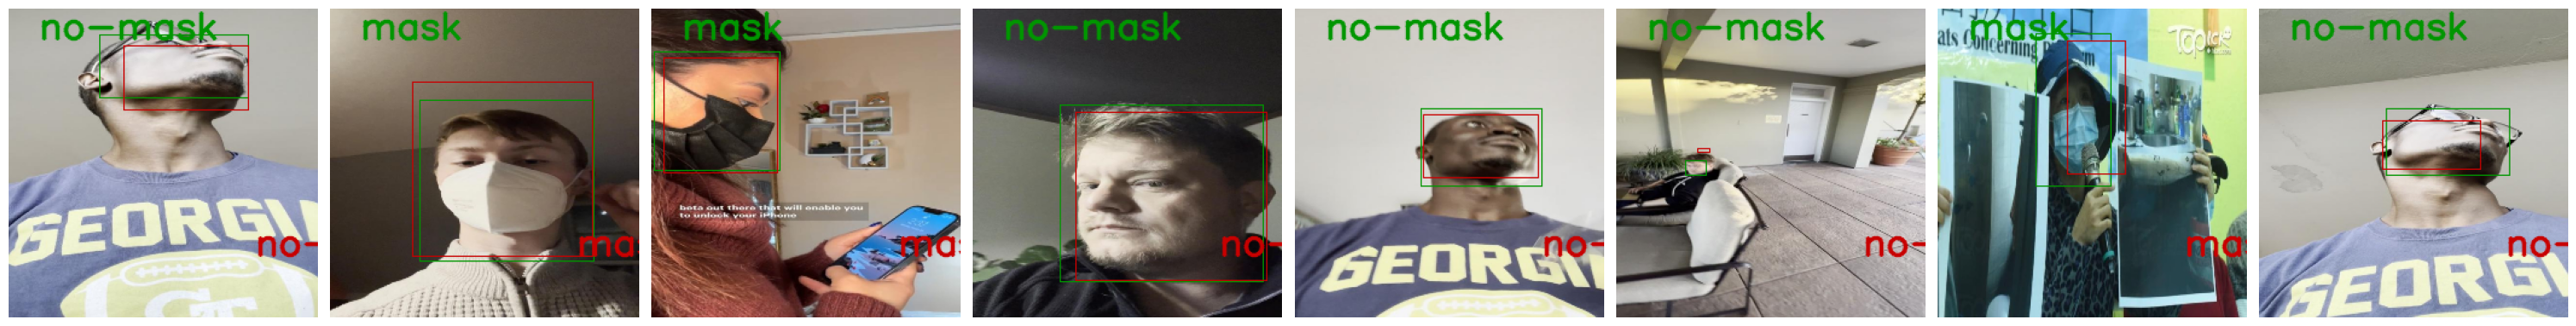

In [51]:
# ===========================
# VISUALIZACIÓN: GT (verde) vs PRED (rojo) — versión robusta
# ===========================

# Determinar cuántos ejemplos hay realmente en cada lista/salida
n = min(len(imgs), len(bboxes), len(pred_bboxes), len(pred_classes))

# --- GT en VERDE ---
imgs = draw_predictions(
    imgs[:n], classes[:n], bboxes[:n],
    [(0, 150, 0)], (int(w*0.1), int(h*0.1)),
    thickness=1, fontScale=1
)

# --- PRED en ROJO ---
# Adaptar clases predichas al formato esperado por draw_predictions
pred_classes_ = [np.array([c]) for c in pred_classes[:n]]

imgs = draw_predictions(
    imgs[:n], pred_classes_, pred_bboxes[:n],
    [(200, 0, 0)], (int(w*0.8), int(h*0.8)),
    thickness=1, fontScale=1
)

# --- GRID de visualización ---
# Recalcular filas/columnas en función de n
ncols_eff = min(ncols, n)             # ncols original si cabe; si no, recorta
nrows_eff = math.ceil(n / ncols_eff)

fig, axes = plt.subplots(nrows=nrows_eff, ncols=ncols_eff, figsize=(30, 30))

# Asegurar un iterable 1D de ejes
axes_flat = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

for i in range(n):
    axes_flat[i].imshow(imgs[i])
    axes_flat[i].axis('off')

# Ocultar ejes sobrantes si la grilla es más grande que n
for j in range(n, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()

In [52]:
# Guarda el **modelo completo** (arquitectura + pesos) en disco.
# Pros: se carga directo con torch.load('pretrained_model.pth').
# Contras: menos portable (depende de la clase/código exacto).
# Alternativa recomendada: guardar solo pesos → model.state_dict()
#   torch.save(model.state_dict(), 'model_state.pth')
#   model = Model(input_shape=(3,640,640), n_classes=2)
#   model.load_state_dict(torch.load('model_state.pth', map_location='cpu'))
torch.save(model, 'pretrained_model.pth')


# Submission

In [53]:
# Detectar dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Usando: {device}')
model = model.to(device)
model.eval()  # modo inferencia

# Rutas y datos de test
test_root_dir = osp.join(DATA_DIR, "images")
test_df = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

# Dataset de test (usa tu clase correcta: maskDataset)
test_ds = maskDataset(
    test_df,
    root_dir=test_root_dir,
    labeled=False,
    transform=eval_transforms,
    output_size=(w, h)
)

# DataLoader de test
test_data = DataLoader(test_ds, batch_size=1, num_workers=cpu_count(), shuffle=False)

# Listas de salida
class_preds, bbox_preds = [], []

# Bucle de inferencia
with torch.no_grad():
    for batch in test_data:
        imgs = batch['image'].float().to(device)
        out = model(imgs)

        # Predicciones
        class_pred = out['class_id'].argmax(dim=-1).detach().cpu().numpy()
        bbox_pred = out['bbox'].detach().cpu().numpy()

        # Guardar
        class_preds.append(class_pred.squeeze())
        bbox_preds.append(bbox_pred.squeeze())

Usando: cuda


In [54]:
# Convertir las listas de predicciones en arreglos de NumPy
# Esto facilita operaciones vectorizadas y el posterior guardado en archivo de submission
class_preds = np.array(class_preds)   # Arreglo con las clases predichas (una por imagen)
bbox_preds = np.array(bbox_preds)     # Arreglo con las cajas predichas (coordenadas por imagen)

In [55]:
submission = pd.DataFrame(  
    index=test_df.filename,   # Usar los nombres de archivo del conjunto de test como índice  
    data={  
        'class': class_preds,  # Columna con las clases predichas para cada imagen  
        }  
)  
submission   # Mostrar el DataFrame de submission (con índice y columna de predicciones)  


,class
filename,
IMG_4861_mp4-50_jpg.rf.7173e37ed9f62f8939af82323289faf2.jpg,0
video_CDC-YOUTUBE_mp4-58_jpg.rf.370d5f316397477da0ff4f44799b1da9.jpg,1
video_CDC-YOUTUBE_mp4-57_jpg.rf.de4856b9a314980e4113335576f453a8.jpg,1
IMG_3102_mp4-0_jpg.rf.6a18575fb4bf7f69cc9006b9a5f34e08.jpg,0
IMG_3094_mp4-34_jpg.rf.11eecb9601680286dc8338d5e8b9acb2.jpg,0
IMG_3100_mp4-22_jpg.rf.5cd5ee55e81838ff0a10d41a906e4811.jpg,1
IMG_4861_mp4-22_jpg.rf.287fa919e56ae28def30735639851d1c.jpg,0
012106_jpg_1140x855_jpg.rf.b784fe385fa3967de70f9d20c0c73429.jpg,1
IMG_0873_mp4-5_jpg.rf.221b34cf6b46d41a81d674baec581a14.jpg,0


In [56]:
submission["xmin"] = bbox_preds[:, 0]*w_real  # Coordenada X mínima de la caja, escalada al ancho real de la imagen
submission["ymin"] = bbox_preds[:, 1]*h_real  # Coordenada Y mínima de la caja, escalada a la altura real de la imagen
submission["xmax"] = bbox_preds[:, 2]*w_real  # Coordenada X máxima de la caja, escalada al ancho real de la imagen
submission["ymax"] = bbox_preds[:, 3]*h_real  # Coordenada Y máxima de la caja, escalada a la altura real de la imagen


In [57]:
submission['class'] = submission['class'].replace(id2obj)  # Reemplaza los IDs de clase numéricos por sus nombres/etiquetas reales usando el diccionario id2obj


In [58]:
submission['class'].value_counts()  # Muestra la cantidad de predicciones por cada clase (frecuencia de cada etiqueta en el submission)


class
no-mask    30
mask       25
Name: count, dtype: int64

In [59]:
submission  # Muestra el DataFrame completo con las predicciones (clase y coordenadas de las cajas por imagen)


,class,xmin,ymin,xmax,ymax
filename,,,,,
IMG_4861_mp4-50_jpg.rf.7173e37ed9f62f8939af82323289faf2.jpg,no-mask,165.713409,75.939949,480.238068,226.034927
video_CDC-YOUTUBE_mp4-58_jpg.rf.370d5f316397477da0ff4f44799b1da9.jpg,mask,209.042648,234.867279,382.075134,352.342834
video_CDC-YOUTUBE_mp4-57_jpg.rf.de4856b9a314980e4113335576f453a8.jpg,mask,213.649628,235.639893,384.143921,349.501953
IMG_3102_mp4-0_jpg.rf.6a18575fb4bf7f69cc9006b9a5f34e08.jpg,no-mask,137.236069,149.228577,496.477295,398.685944
IMG_3094_mp4-34_jpg.rf.11eecb9601680286dc8338d5e8b9acb2.jpg,no-mask,177.257507,203.175171,513.554626,474.834625
IMG_3100_mp4-22_jpg.rf.5cd5ee55e81838ff0a10d41a906e4811.jpg,mask,187.145767,185.259857,525.528931,419.712524
IMG_4861_mp4-22_jpg.rf.287fa919e56ae28def30735639851d1c.jpg,no-mask,54.823170,184.982376,287.528137,398.466797
012106_jpg_1140x855_jpg.rf.b784fe385fa3967de70f9d20c0c73429.jpg,mask,293.657288,129.566589,369.511230,305.881042
IMG_0873_mp4-5_jpg.rf.221b34cf6b46d41a81d674baec581a14.jpg,no-mask,189.399033,114.779709,515.698364,400.593689


In [60]:
submission.to_csv('submission_fastrcnn_14epoch.csv')  # Exporta el DataFrame de submission a un archivo CSV con el nombre 'submission_vgg16.csv'
